In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import env

# function to deal with parsing one entry in our log data
def parse_log_entry(entry):
    parts = entry.split()
    output = {}
    output['ip'] = parts[0]
    output['timestamp'] = parts[3][1:].replace(':', ' ', 1)
    output['request_method'] = parts[5][1:]
    output['request_path'] = parts[6]
    output['http_version'] = parts[7][:-1]
    output['status_code'] = parts[8]
    output['size'] = int(parts[9])
    output['user_agent'] = ' '.join(parts[11:]).replace('"', '')
    return pd.Series(output)

url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/logs'
df = pd.read_sql('SELECT * FROM api_access', url)
df = df.entry.apply(parse_log_entry)


# Synthetic data
new = pd.DataFrame([
    ["95.31.18.119", "21/Apr/2019 10:02:41", "GET", "/api/v1/items/", "HTTP/1.1", '200', 1153005, "python-requests/2.21.0"],
    ["95.31.16.121", "17/Apr/2019 19:36:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '301', 1005, "python-requests/2.21.0"],
    ["97.105.15.120", "18/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '301', 2560, "python-requests/2.21.0"],
    ["97.105.19.58", "19/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '200', 2056327, "python-requests/2.21.0"],
], columns=df.columns)

df = df.append(new)

df['size_mb'] = df['size'] / 1024 / 1024
df.timestamp = pd.to_datetime(df.timestamp, utc=True)
df = df.set_index('timestamp')
df.head()

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-16 19:34:42+00:00,97.105.19.58,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0,0.488753
2019-04-16 19:34:42+00:00,97.105.19.58,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0,0.003396
2019-04-16 19:34:44+00:00,97.105.19.58,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0,0.486472
2019-04-16 19:34:46+00:00,97.105.19.58,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0,0.486377
2019-04-16 19:34:48+00:00,97.105.19.58,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0,0.488246


In [2]:
request_path_and_params = df.request_path.str.split('?', expand=True)
request_path_and_params.columns = ['request_path', 'request_params']
df = df.drop(columns='request_path').join(request_path_and_params)

<AxesSubplot:title={'center':'Top 10 Most Commonly Requested Pages'}>

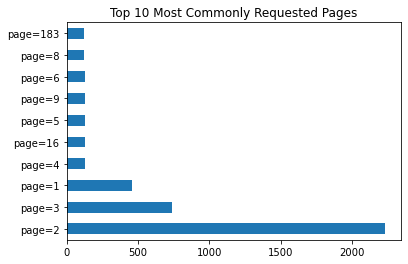

In [3]:
df.request_params.value_counts().head(10).plot.barh(
    title='Top 10 Most Commonly Requested Pages',
)

Interesting that page 2 is the most requested, and page 1 is the #3. Also page 183 makes the top 10.

In [4]:
df = df.tz_convert('America/Chicago')
df['hour'] = df.index.hour
df['weekday'] = df.index.day_name()

<AxesSubplot:title={'center':'Which hours are the most active?'}>

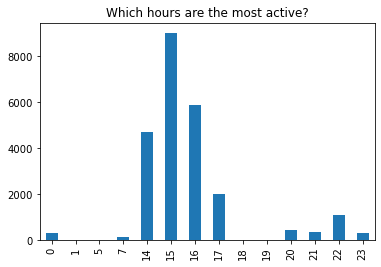

In [5]:
df.hour.value_counts().sort_index().plot.bar(title='Which hours are the most active?')

The afternoon seems to be the most common time, followed by the evening

In [6]:
df.groupby('hour').request_params.value_counts(normalize=True).sort_values()

hour  request_params           
14    page=999                     0.000483
      page=99999999999999999998    0.000725
      page=79/                     0.000725
      page=666                     0.000967
      page=1                       0.001208
                                     ...   
23    page=3                       0.274611
      page=2                       0.326425
19    page=2                       0.500000
      page=3                       0.500000
1     page=1                       1.000000
Name: request_params, Length: 1619, dtype: float64

* Whoever is working very early in the morning only requested page 1
* At 7:00 people either request page 2 or 3

In [7]:
df.groupby('request_params').hour.value_counts(normalize=True).sort_values()

request_params             hour
page=2                     7       0.000447
                           19      0.000895
page=3                     7       0.001357
                           19      0.002714
page=4                     23      0.007576
                                     ...   
page=0                     14      1.000000
page=666                   14      1.000000
page=999                   14      1.000000
page=79/                   14      1.000000
page=99999999999999999998  14      1.000000
Name: hour, Length: 1619, dtype: float64

The requests to pages that don't exist only happened at 2:00.

In [8]:
df.groupby('weekday').request_params.value_counts(normalize=True)

weekday    request_params
Friday     page=79/          1.000000
Thursday   page=79/          1.000000
Tuesday    page=2            0.103214
           page=3            0.033179
           page=1            0.020077
                               ...   
Wednesday  page=95           0.002433
           page=96           0.002433
           page=97           0.002433
           page=98           0.002433
           page=99           0.002433
Name: request_params, Length: 373, dtype: float64

There's a couple requests for page 79 on thursday and friday.